# Chapter 1 

Case study for this chapter is on Cycle Sharing Scheme - determining Brand Persona

The aim is to "_lay out a strong marketing plan for reaching out to potential customers_"

Infrastructure expansion (more bikes and docking stations) by Jason, the Owner, did not result in increase rate of customer sign-ups nor customer retention

Questions by marketer Nancy, and Data Analyst Eric:
1. which attributes correlates the best with trip duration and number of trips?
1. which age generation adapts the most to the service?


In [158]:
# Listing 1-1

%matplotlib inline

import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
import scipy
from scipy import stats
import seaborn as sns


### Some information about the service

- The service has 500 bikes at 50 stations across Seattle. 
- Each of the stations has a dock locking system (where all bikes are parked); 
    - kiosks (so customers can get a membership key or pay for a trip); and 
    - a helmet rental service. 
- A person can choose between purchasing 
    - a membership key or 
    - short-term pass. 
- A membership key entitles an annual membership, and the key can be obtained from a kiosk. 
- Advantages for members include 
    - quick retrieval of bikes and 
    - unlimited 45-minute rentals. 
- Short-term passes offer access to bikes for 
    - a 24-hour or 
    - 3-day time interval. 
- Riders can avail and return the bikes at any of the 50 stations citywide.

Table 1-1. Data Dictionary for the Trips Data from Cycles Share Dataset

|Feature name | Description|
|:----|:----|
|trip_id|Unique ID assigned to each trip|
|Starttime|Day and time when the trip started, in PST|
|Stoptime|Day and time when the trip ended, in PST|
|Bikeid |ID attached to each bike|
|Tripduration |Time of trip in seconds|
|from_station_name | Name of station where the trip originated|
| to_station_name | Name of station where the trip terminated|
| from_station_id | ID of station where trip originated
|to_station_id |ID of station where trip terminated |
|Usertype |Value can include either of the following: short-term pass holder or member|
|Gender |Gender of the rider |
|Birthyear|Birth year of the rider |


In [159]:
# Listing 1-2

data = pd.read_csv('../data/raw/trip.csv')

In [160]:
data.shape

(236065, 12)

Dataset has 236065 records (rows) and 12 features (columns)

In [161]:
# Listing 1-3

print(len(data))
data.head()

236065


,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
0,431,10/13/2014 10:31,10/13/2014 10:48,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1960.0
1,432,10/13/2014 10:32,10/13/2014 10:48,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1970.0
2,433,10/13/2014 10:33,10/13/2014 10:48,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1988.0
3,434,10/13/2014 10:34,10/13/2014 10:48,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1977.0
4,435,10/13/2014 10:34,10/13/2014 10:49,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1971.0


In [162]:
data.describe()

,trip_id,tripduration,birthyear
count,236065.000,236065.000,146167.000
mean,130059.869,1202.612,1979.880
std,72842.289,2066.425,10.155
min,431.000,60.008,1931.000
25%,67746.000,392.265,1975.000
50%,130526.000,633.235,1983.000
75%,192900.000,1145.015,1987.000
max,255245.000,28794.398,1999.000


The above describe() analysis picks out the numerical features in the dataset. `trip_id` and `birthyear` distribution is nonsensical, so these 2 features need to be converted. And it seems, `birthyear` has some missing values.

`tripduration` is in seconds and does not tally against description or metrics discussed, so better to convert to minutes for analysis.

In [163]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236065 entries, 0 to 236064
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   trip_id            236065 non-null  int64  
 1   starttime          236065 non-null  object 
 2   stoptime           236065 non-null  object 
 3   bikeid             236065 non-null  object 
 4   tripduration       236065 non-null  float64
 5   from_station_name  236065 non-null  object 
 6   to_station_name    236065 non-null  object 
 7   from_station_id    236065 non-null  object 
 8   to_station_id      236065 non-null  object 
 9   usertype           236065 non-null  object 
 10  gender             146171 non-null  object 
 11  birthyear          146167 non-null  float64
dtypes: float64(2), int64(1), object(9)
memory usage: 21.6+ MB


Observations on the data:
- `tripduration` is in seconds
- `trip_id` is an int
- `starttime` and `stoptime` are strings. In order to perform datetime analysis, date features needs to be converted to DateTime format.
- `gender` and `birthyear` have missing values
- dataset does not provide userid, or any other identifiers for users. So there's no way to tell if same trips were taken repeatly by the same customers or different ones or even, a new customer. Therefore, we have no way of of telling if the trips are by new customers or not. Also does not contain length of membership for members of the service.
- however, there's `bikeid` that can be analysed if repeat trips of a particular bike, from or to the same kiosks

In [164]:
print(f"% of missing 'gender': {(data['gender'].isnull().sum())/len(data)*100:.2f}")
print(f"% of missing 'birthyear': {(data['birthyear'].isnull().sum())/len(data)*100:.2f}")

% of missing 'gender': 38.08
% of missing 'birthyear': 38.08


In [165]:
data.tail()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
236060,255241,8/31/2016 23:34,8/31/2016 23:45,SEA00201,679.532,Harvard Ave & E Pine St,2nd Ave & Spring St,CH-09,CBD-06,Short-Term Pass Holder,NaN,NaN
236061,255242,8/31/2016 23:48,9/1/2016 0:20,SEA00247,1965.418,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN
236062,255243,8/31/2016 23:47,9/1/2016 0:20,SEA00300,1951.173,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN
236063,255244,8/31/2016 23:49,9/1/2016 0:20,SEA00047,1883.299,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN
236064,255245,8/31/2016 23:49,9/1/2016 0:20,SEA00442,1896.031,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN


### Converting date columns to DateTime format

In [166]:
for date_col in ['starttime', 'stoptime']:
    data[date_col] = pd.to_datetime(data[date_col], format = "%m/%d/%Y %H:%M")

### Sort by `starttime`

In [167]:
data = data.sort_values(by='starttime', ascending=True)
data.reset_index()

,index,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
0,0,431,2014-10-13 10:31:00,2014-10-13 10:48:00,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1960.0
1,1,432,2014-10-13 10:32:00,2014-10-13 10:48:00,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1970.0
2,2,433,2014-10-13 10:33:00,2014-10-13 10:48:00,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1988.0
3,3,434,2014-10-13 10:34:00,2014-10-13 10:48:00,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1977.0
4,4,435,2014-10-13 10:34:00,2014-10-13 10:49:00,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1971.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
236060,236060,255241,2016-08-31 23:34:00,2016-08-31 23:45:00,SEA00201,679.532,Harvard Ave & E Pine St,2nd Ave & Spring St,CH-09,CBD-06,Short-Term Pass Holder,NaN,NaN
236061,236062,255243,2016-08-31 23:47:00,2016-09-01 00:20:00,SEA00300,1951.173,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN
236062,236061,255242,2016-08-31 23:48:00,2016-09-01 00:20:00,SEA00247,1965.418,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN
236063,236063,255244,2016-08-31 23:49:00,2016-09-01 00:20:00,SEA00047,1883.299,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,NaN


### Determine earliest and last date/time of records

Insight from below analysis:
- data is collected for 3 years, from October 2014 - September 2016
- service is operational beyond traditional 9-5 office operational hours

In [168]:
print(f"first entry in starttime series: {data['starttime'][0]}")
print(f"last entry in stoptime series: {data['stoptime'][len((data))-1]}")

first entry in starttime series: 2014-10-13 10:31:00
last entry in stoptime series: 2016-09-01 00:20:00


## Univariate Analysis

In [169]:
# Listing 1-4

# data = data.sort_values(by='starttime', ascending=True)
# data.reset_index()
# print('Date range of dataset: %s - %s'%(data.ix[1, 'starttime'], data.ix[len(data)-1, 'stoptime']))


In [170]:
print(f"Date range of dataset : {data['starttime'][0]} - {data['stoptime'][len((data))-1]}")

Date range of dataset : 2014-10-13 10:31:00 - 2016-09-01 00:20:00


### Plotting Distribution of User Types

Analysing who uses the service more: members or short-term pass holders?

Seems that `usertype` **Member** is the majority of cyclers in Seattle who uses this bike-sharing service. 

<Axes: title={'center': 'Distribution of user types'}, xlabel='usertype'>

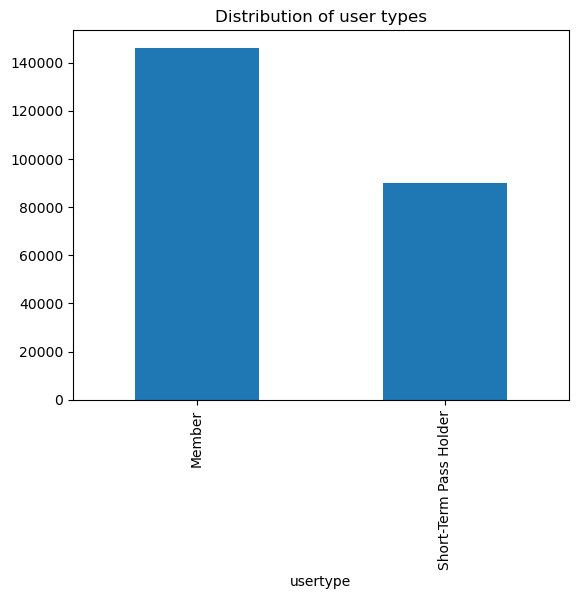

In [171]:
# Listing 1-5

groupby_user = data.groupby('usertype').size()
groupby_user.plot.bar(title = 'Distribution of user types')

### Plotting Distribution by Gender

Similarly, wondered whether Males or Females are the main users?

Seems that `gender` **Male** is the majority of cyclers in Seattle who uses this bike-sharing service. 

<Axes: title={'center': 'Distribution of genders'}, xlabel='gender'>

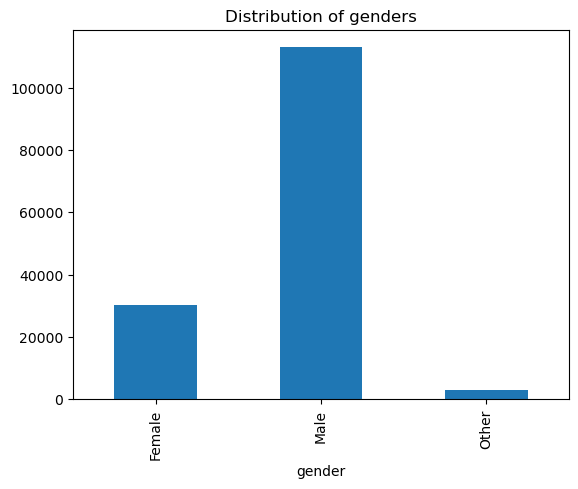

In [172]:
# Listing 1-6

groupby_gender = data.groupby('gender').size()
groupby_gender.plot.bar(title = 'Distribution of genders')

### Plotting Distribution by BirthYear

Analysing what age group of users utilised the service more?

Seems that users born between early 1980s and late 1990s formed the majority of cyclers in Seattle who uses this bike-sharing service. 

<Axes: title={'center': 'Distribution of birth years'}, xlabel='birthyear'>

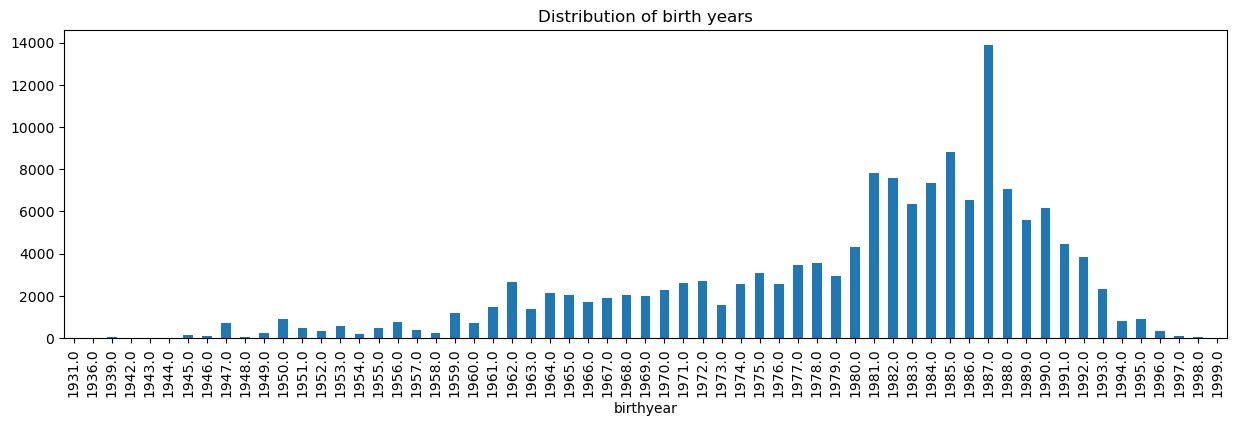

In [173]:
# Listing 1-7

data = data.sort_values(by='birthyear')
groupby_birthyear = data.groupby('birthyear').size()
groupby_birthyear.plot.bar(title = 'Distribution of birth years', figsize = (15,4))

### Plotting Distribution by Frequency of usage by Member Types for Millenials

Analysing among millenials (i.e. born in the early 1980s to mid to late 1990s) who uses the service, are they members or pass-holders?

Seems that `usertype` Member is the type of cyclers among Millenials, in Seattle who uses this bike-sharing service. 

<Axes: title={'center': 'Distribution of user types by birthyear between 1977 and 1994'}, xlabel='usertype'>

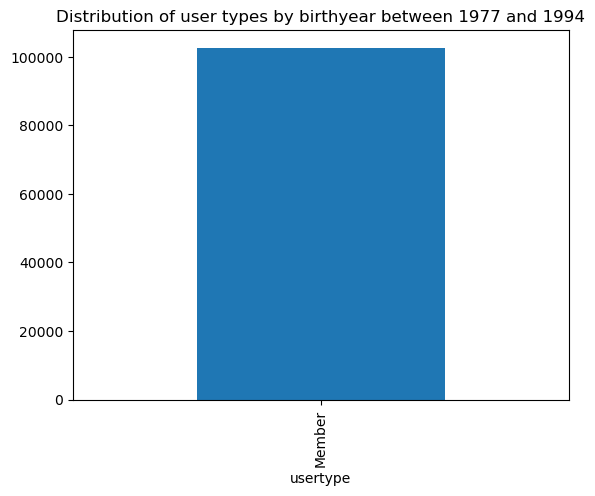

In [174]:
# Listing 1-8

data_millenials = data[(data['birthyear'] >= 1977) & (data['birthyear']<=1994)]
groupby_millenials = data_millenials.groupby('usertype').size()
groupby_millenials.plot.bar(title = 'Distribution of user types by birthyear between 1977 and 1994')

## Multivariate Analysis

### Plotting the Distribution of Birth Years by Gender Type

Insight gained from graph is that indeed all cyclists who used the service where mostly men, execpt for those born in 1947 were all Women. Which makes sense as that is close to when the 2nd World War concluded, and thus explained the shortage of men everywhere.

<Axes: title={'center': 'Distribution of birth years by Gender'}, xlabel='birthyear'>

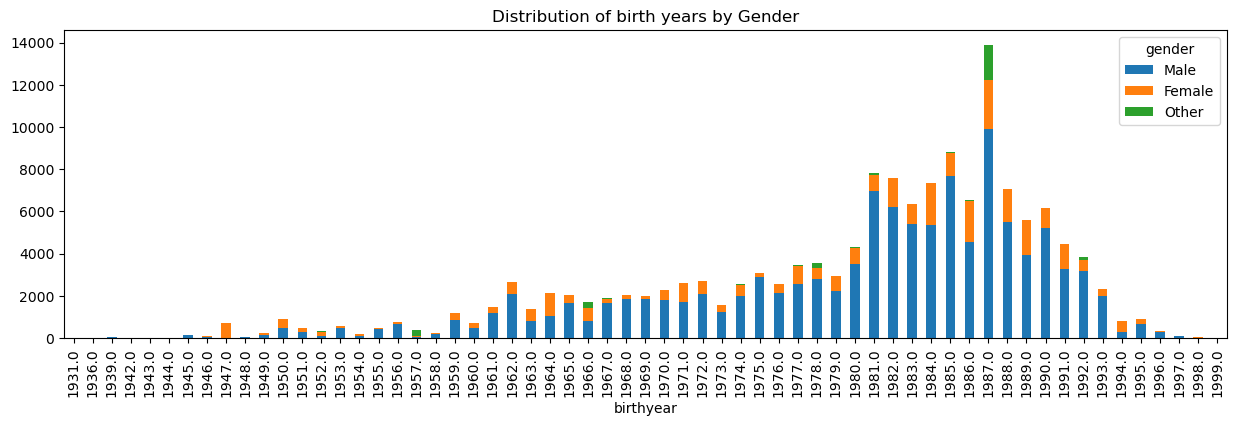

In [175]:
# Listing 1-9

groupby_birthyear_gender = data.groupby(['birthyear', 'gender'])['birthyear'].count().unstack('gender').fillna(0)
groupby_birthyear_gender[['Male','Female','Other']].plot.bar(title = 'Distribution of birth years by Gender', stacked=True, figsize = (15,4))

### Plotting the Distribution of Birth Years by User Types

Only Members have their `birthyear` data recorded.

<Axes: title={'center': 'Distribution of birth years by Usertype'}, xlabel='birthyear'>

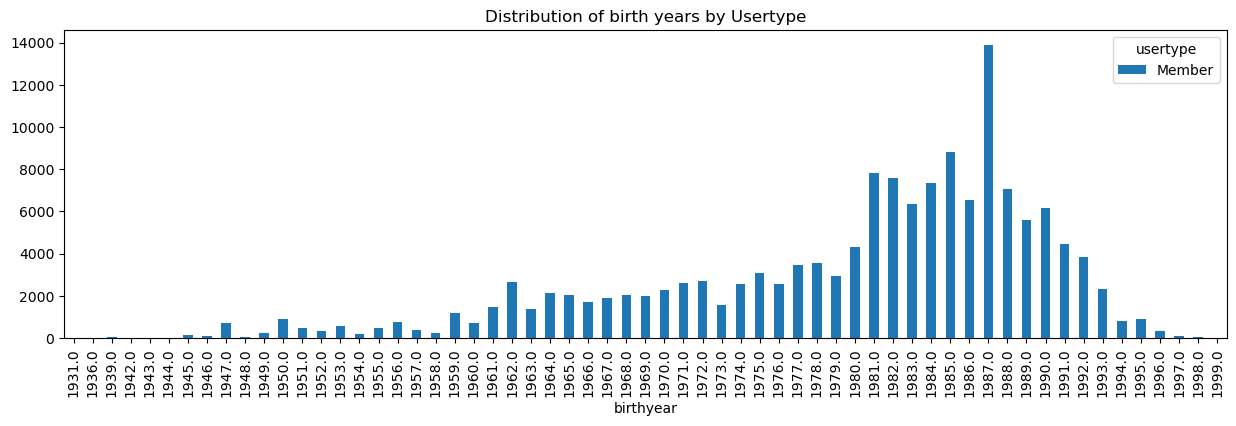

In [176]:
# Listing 1-10

groupby_birthyear_user = data.groupby(['birthyear', 'usertype'])['birthyear'].count().unstack('usertype').fillna(0)
groupby_birthyear_user.plot.bar(title = 'Distribution of birth years by Usertype', stacked=True, figsize = (15,4))

### Validation If We Don’t Have Birth Year Available for Short-Term Pass Holders

Conclusion:  loyalty of millenials can’t be validated from the data at hand

In [177]:
# Listing 1-11

data[data['usertype']=='Short-Term Pass Holder']['birthyear'].isnull().values.all()

True

### Validation If We Don’t Have Gender Available for Short-Term Pass Holders

 Demographic variables for user type ‘Short-Term Pass holders’ is not recorded either.

In [178]:
# Listing 1-12

data[data['usertype']=='Short-Term Pass Holder']['gender'].isnull().values.all()

True

### Converting String to datetime, and Deriving New Features

In [179]:
# Listing 1-13

List_ = list(data['starttime'])

# List_ = [datetime.datetime.strptime(x, "%m/%d/%Y %H:%M") for x in List_]
data['starttime_mod'] = pd.Series(List_,index=data.index)
data['starttime_date'] = pd.Series([x.date() for x in List_],index=data.index)
data['starttime_year'] = pd.Series([x.year for x in List_],index=data.index)
data['starttime_month'] = pd.Series([x.month for x in List_],index=data.index)
data['starttime_day'] = pd.Series([x.day for x in List_],index=data.index)
data['starttime_hour'] = pd.Series([x.hour for x in List_],index=data.index)

In [180]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data['starttime_dayofweek'] = pd.Series([days[x.weekday()] for x in List_],index=data.index)

### Plotting the Distribution of Trip Duration over Daily Time

There seems to be a definitive (cyclical) pattern of trip duration over time.

<Axes: title={'center': 'Distribution of Trip duration by date'}, xlabel='starttime_date'>

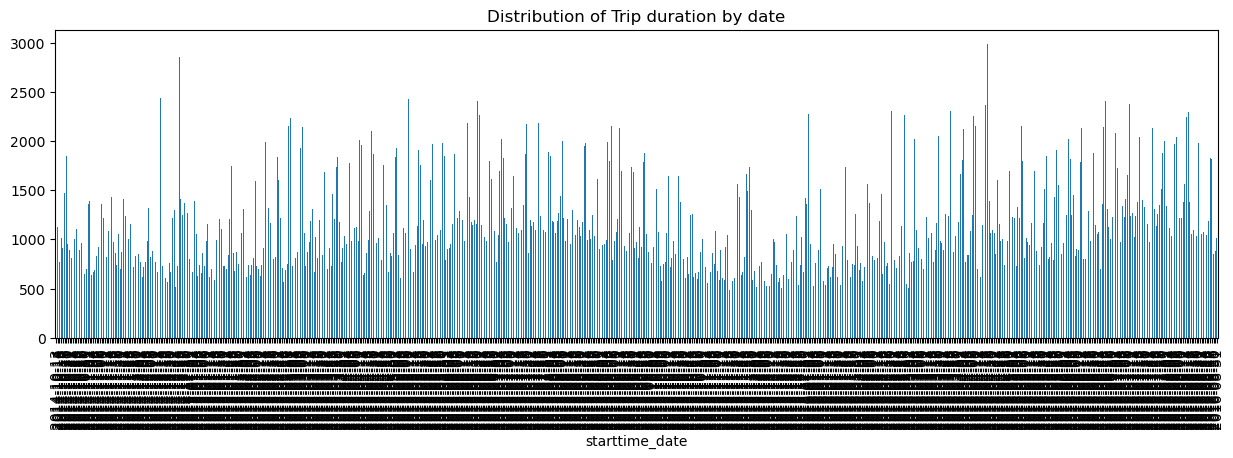

In [181]:
# Listing 1-14

data.groupby('starttime_date')['tripduration'].mean().plot.bar(title = 'Distribution of Trip duration by date', figsize = (15,4))

### Exercises

1. determine the distribution of number of trips by *year*. do you see a specific pattern?
    - there's an increasing trend over the years of increased usage. can we determine by membership or pass-holders?
2. determine the distribution of number of trips by *month*. do you see a specific pattern?
    - more trips made in the Summer months
3. determine the distribution of number of trips by *day*. do you see a specific pattern?
    - no discernable pattern by date of Month, however there is a slight bump every 7 days; perhaps need to plot days of the week?
    - without referencing a Calendar, not known what days of the week each date falls on
    - ploting by day of week shows more bike rides on the weekends
4. determine the distribution of number of trips by ~~day~~ *hour*. do you see a specific pattern?
    - more trips during working hours of 10am - 4pm, and surprising at wee hours between 1am - 3am.
5. plot a frequency distribution of trips on a daily basis.
    - isn't this 'Distribution of Trip duration by date' above? Histogram of daily trips?


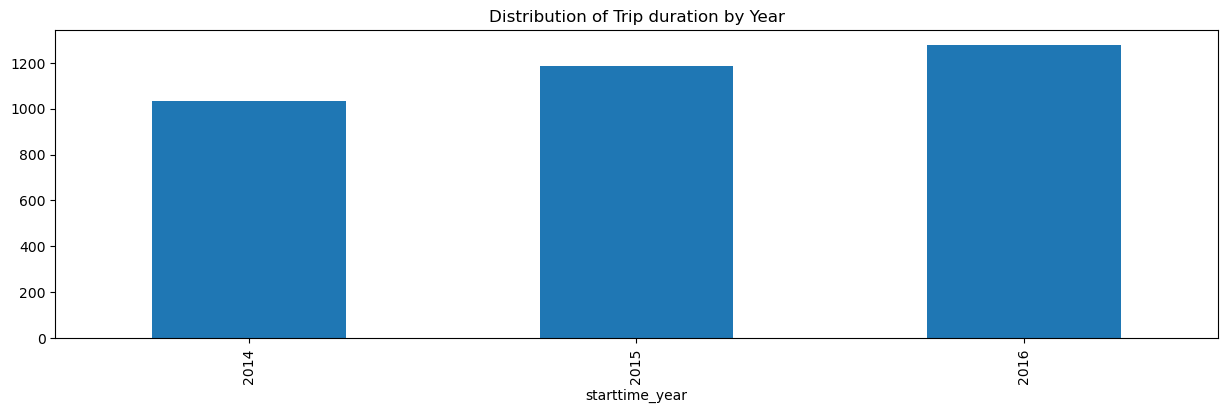

In [182]:
# Ex 1
data.groupby('starttime_year')['tripduration'].mean().plot.bar(title = 'Distribution of Trip duration by Year', figsize = (15,4))
plt.show()

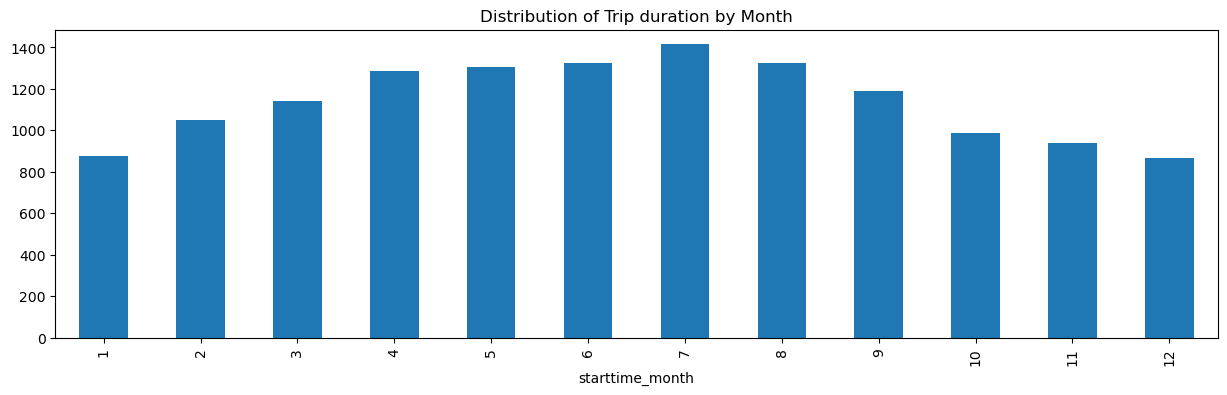

In [183]:
# Ex 2
data.groupby('starttime_month')['tripduration'].mean().plot.bar(title = 'Distribution of Trip duration by Month', figsize = (15,4))
plt.show()

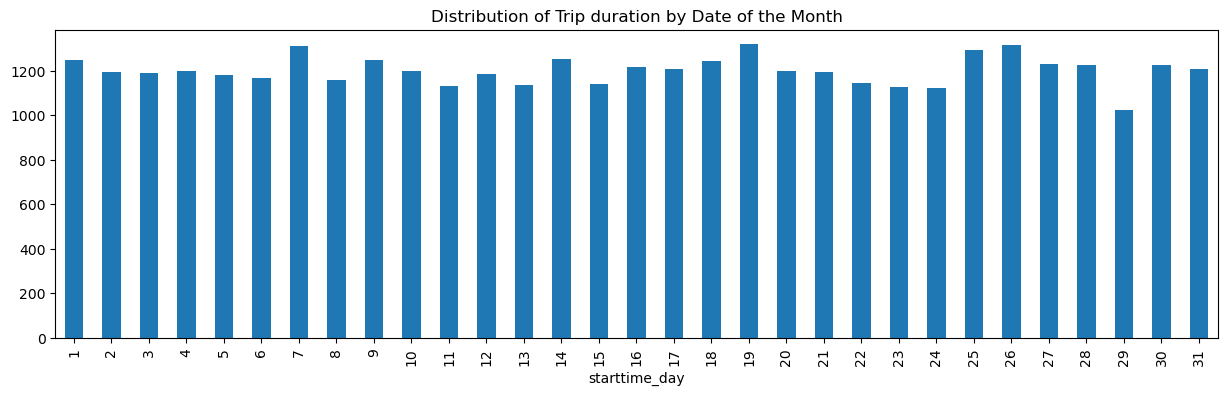

In [184]:
# Ex 3a
data.groupby('starttime_day')['tripduration'].mean().plot.bar(title = 'Distribution of Trip duration by Date of the Month', figsize = (15,4))
plt.show()

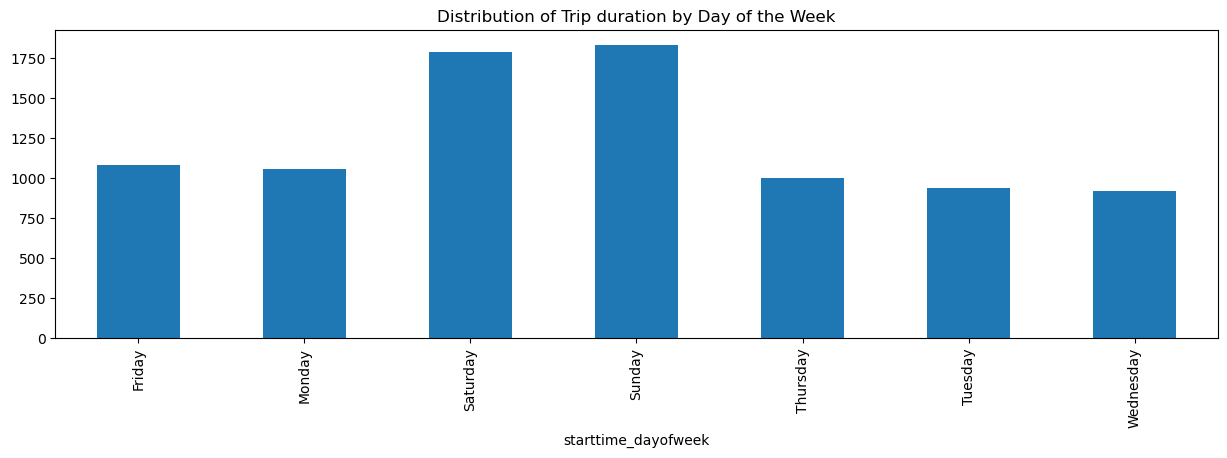

In [185]:
# Ex 3b
data.groupby('starttime_dayofweek')['tripduration'].mean().plot.bar(title = 'Distribution of Trip duration by Day of the Week', figsize = (15,4))
plt.show()

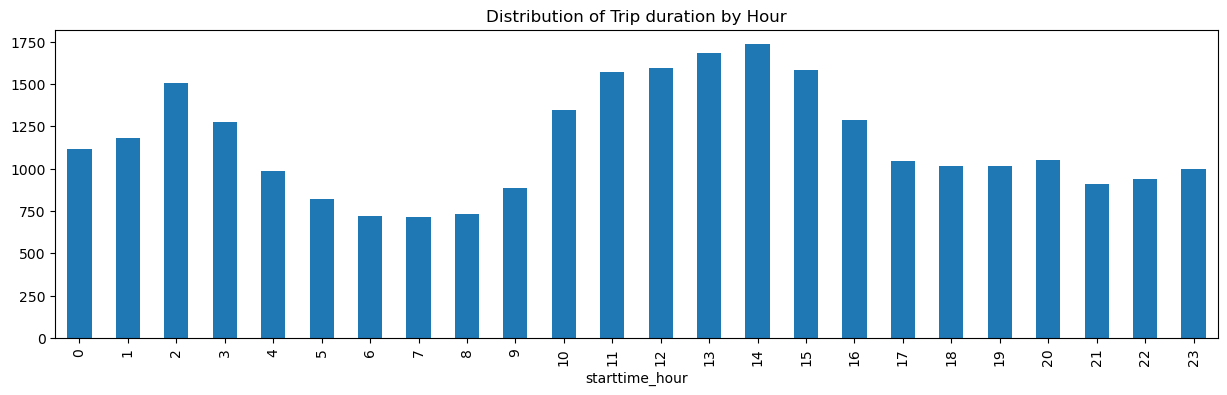

In [186]:
data.groupby('starttime_hour')['tripduration'].mean().plot.bar(title = 'Distribution of Trip duration by Hour', figsize = (15,4))
plt.show()

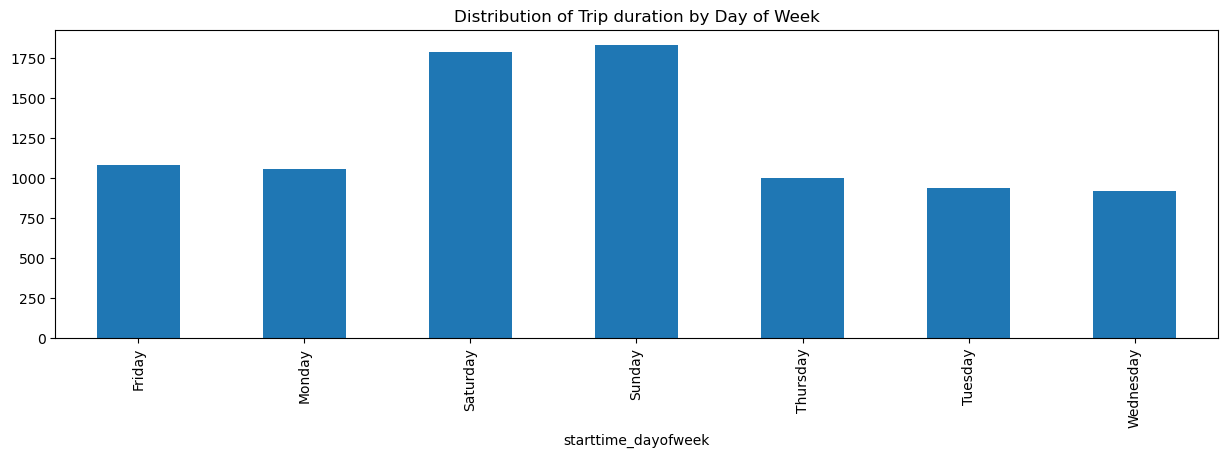

In [187]:
data.groupby('starttime_dayofweek')['tripduration'].mean().plot.bar(title = 'Distribution of Trip duration by Day of Week', figsize = (15,4))
plt.show()

In [188]:
df_ = data.groupby('starttime_dayofweek')['trip_id'].count()
df_

starttime_dayofweek
Friday       35828
Monday       34704
Saturday     31724
Sunday       27401
Thursday     36122
Tuesday      35023
Wednesday    35263
Name: trip_id, dtype: int64

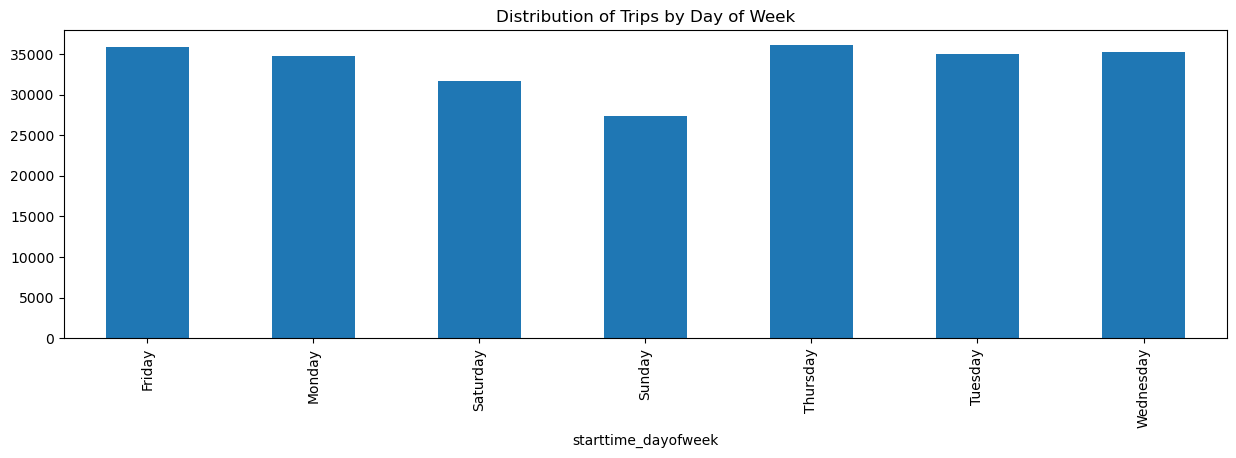

In [189]:
data.groupby('starttime_dayofweek')['trip_id'].count().plot.bar(title = 'Distribution of Trips by Day of Week', figsize = (15,4))
plt.show()

### Determining the Measures of Center Using Statistics Package

 note: *determining the measures of centers using the statistics package will require us to transform the input data structure to a list type.*

- most trips originatef from Pier 69 / Alaskan Way & Clay St
    - makes this the ideal location for running promotional campaigns targeted to existing customers.
- shows mean (average) to be greater than that of the median (central value)

In [190]:
# Listing 1-15

trip_duration = list(data['tripduration'])
station_from = list(data['from_station_name'])
print("-- uom in seconds -- ")
print(f"Mean of trip duration: {statistics.mean(trip_duration):.2f} seconds")
print(f"Median of trip duration: {statistics.median(trip_duration):.2f} seconds")
print(f"Mode of station originating from: {statistics.mode(station_from)}")
print()
print("-- converted to mins -- ")
print(f"Mean of trip duration: {statistics.mean(trip_duration)/60:.2f} mins")
print(f"Median of trip duration: {statistics.median(trip_duration)/60:.2f} mins")


-- uom in seconds -- 
Mean of trip duration: 1202.61 seconds
Median of trip duration: 633.24 seconds
Mode of station originating from: Pier 69 / Alaskan Way & Clay St

-- converted to mins -- 
Mean of trip duration: 20.04 mins
Median of trip duration: 10.55 mins


### Plotting Histogram of Trip Duration

excerpt from book:
> The distribution in Figure 1-11 has only one peak (i.e., mode). The distribution is not symmetric and has majority of values toward the right-hand side of the mode. These extreme values toward the right are negligible in quantity, but their extreme nature tends to pull the mean toward themselves. Thus the reason why the mean is greater than the median.
> The distribution in Figure 1-11 is referred to as a normal distribution.

> Normal distribution, or in other words Gaussian distribution, is a continuous probability distribution that is bell shaped. The important characteristic of this distribution is that the mean lies at the center of this distribution with a spread (i.e., standard deviation) around it.

The `tripduration` is *Positively skewed*. This might be due to the presence of outliers.

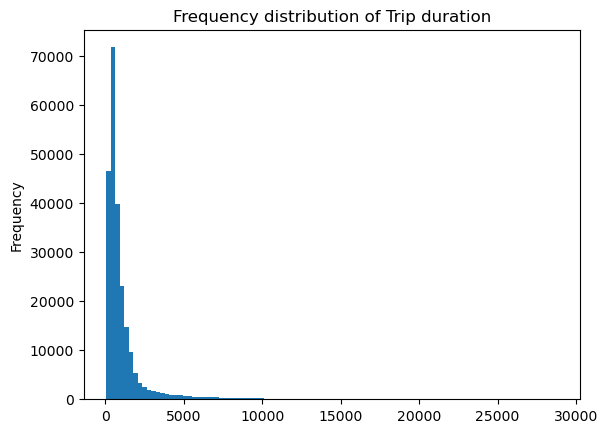

In [191]:
# Listing 1-16

data['tripduration'].plot.hist(bins=100, title='Frequency distribution of Trip duration')
plt.show()

In [192]:
# Listing 1-17

# [Q1 - 1.5 (IQR) ,  Q3 + 1.5 (IQR) ] (i.e. IQR = Q3 - Q1)

### Plotting a Box plot of Trip Duration

All of that black bar are dots of outliers!

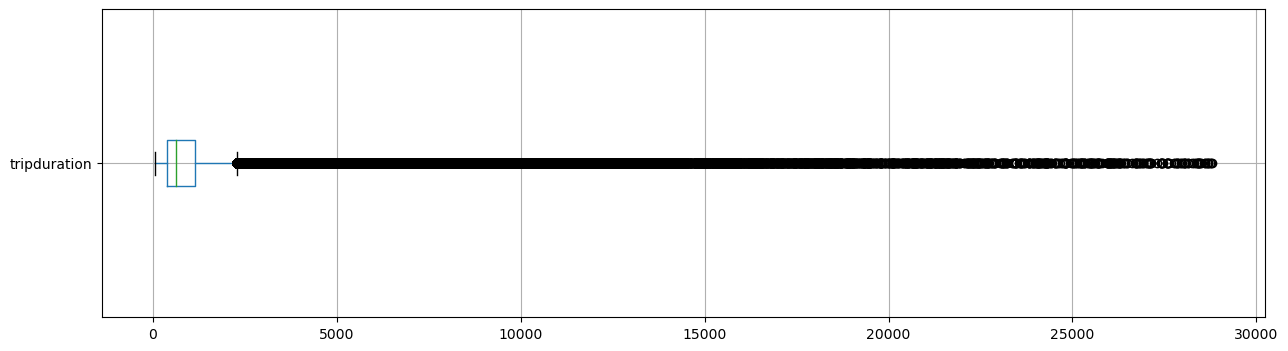

In [193]:
# Listing 1-18

box = data.boxplot(column=['tripduration'], vert=False, figsize = (15,4)) #add vert=False to display chart horizontally
plt.show()

### Determining Ratio of Values in Observations of tripduration Which Are Outliers


In [194]:
# Listing 1-19

q75, q25 = np.percentile(trip_duration, [75 ,25])
iqr = q75 - q25
print(f"Proportion of values as outlier: {((len(data) - len([x for x in trip_duration if q75+(1.5*iqr) >=x>= q25-(1.5*iqr)]))*100/float(len(data))):.4f} percent")

Proportion of values as outlier: 9.5482 percent


Listing 1-20 Formula for Calculating Number of Outliers

`Number of outliers values = Length of all values - Length of all non outliers values`

Listing 1-21 Formula for Calculating Ratio of Outlier Values

`Ratio of outliers = ( Number of outliers values / Length of all values ) * 100`

### Calculating z scores for Observations Lying Within tripduration

excerpt from book:
> Nancy was relieved to see only 9.5% of the values within the dataset to be outliers. Considering the time series nature of the dataset she knew that removing these outliers wouldn’t be an option. Hence she knew that the only option she could rely on was to apply transformation to these outliers to negate their extreme nature. However, she was interested in observing the mean of the non-outlier values of trip duration. This she then wanted to compare with the mean of all values calculated earlier in Listing 1-15.

In [195]:
# Listing 1-22

mean_trip_duration = np.mean([x for x in trip_duration if q75+(1.5*iqr) >=x>= q25-(1.5*iqr)])
upper_whisker = q75+(1.5*iqr)
print('Mean of trip duration: %f'%mean_trip_duration)
print(f"Mean of trip duration: {mean_trip_duration}")

Mean of trip duration: 711.726573
Mean of trip duration: 711.7265734972484


excerpt from book:
> The mean of non-outlier trip duration values in Listing 1-22 (i.e., approximately 712)
is considerably lower than that calculated in the presence of outliers in Listing 1-15 (i.e.,
approximately 1,203). This best describes the notion that mean is highly affected by the
presence of outliers in the dataset.

### Calculating Mean Scores for Observations Lying Within tripduration

In [196]:
# modified for repeated use - 2nd time for males_mean_trip_duration
def transform_tripduration(x, upper, mean):
    
    if x > upper:
        return mean
    return x

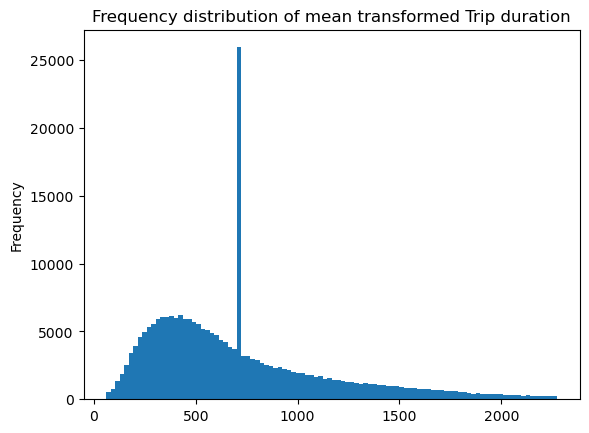

In [197]:
# Listing 1-23

# def transform_tripduration(x):
    
#     if x > upper_whisker:
#         return mean_trip_duration
#     return x

data['tripduration_mean'] = data['tripduration'].apply(lambda x: transform_tripduration(x, upper_whisker, mean_trip_duration))

data['tripduration_mean'].plot.hist(bins=100, title='Frequency distribution of mean transformed Trip duration')
plt.show()

### Determining the Measures of Center in Absence of Outliers

In [198]:
# Listing 1-24

print('Mean of trip duration: %f'%data['tripduration_mean'].mean())
print('Standard deviation of trip duration: %f'%data['tripduration_mean'].std())
print('Median of trip duration: %f'%data['tripduration_mean'].median())

Mean of trip duration: 711.726573
Standard deviation of trip duration: 435.517297
Median of trip duration: 633.235000


##  EXERCISE

1. Find the mean, median, and mode of the trip duration of gender type male.
2. by looking at the numbers obtained earlier, in your opinion is the distribution symmetric or skewed? if skewed, then is is it positively skewed or negatively skewed?
    - positively skewed
3. plot a frequency distribution of trip duration for trips availed by gender type male. does it validate your inference as you did so in the previous question?
4. plot a box plot of the trip duration of trips taken by males. do you think any outliers exist?
5. apply the formula in listing ~~1-6~~ 1-19 to determine the percentage of observations for which outliers exists.
6. perform the treatment of outliers by incorporating one of the methods we discussed earlier for the treatment of outliers.

### Multivariate Measures of Center for `tripduration` and `gender` == 'Male'

In [199]:
# Exercise 1
mask_males = data['gender'] == 'Male'
trip_durations_of_males = list(data[mask_males]['tripduration'])
trip_durations_of_males
print(f"Mean of trip_durations taken by males: {statistics.mean(trip_durations_of_males)/60:.2f} mins")
print(f"Median of trip_durations taken by males: {statistics.median(trip_durations_of_males)/60:.2f} mins")
print(f"Mode of trip_durations taken by males: {statistics.mode(trip_durations_of_males)/60:.2f} mins")

Mean of trip_durations taken by males: 9.39 mins
Median of trip_durations taken by males: 7.64 mins
Mode of trip_durations taken by males: 7.77 mins


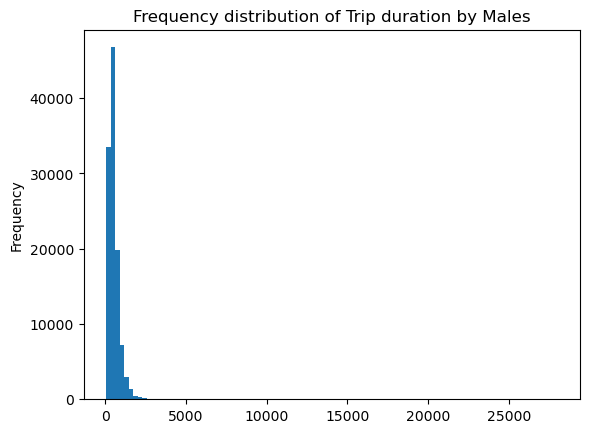

In [200]:
# Exercise 3
data[mask_males]['tripduration'].plot.hist(bins=100, title='Frequency distribution of Trip duration by Males')
plt.show()

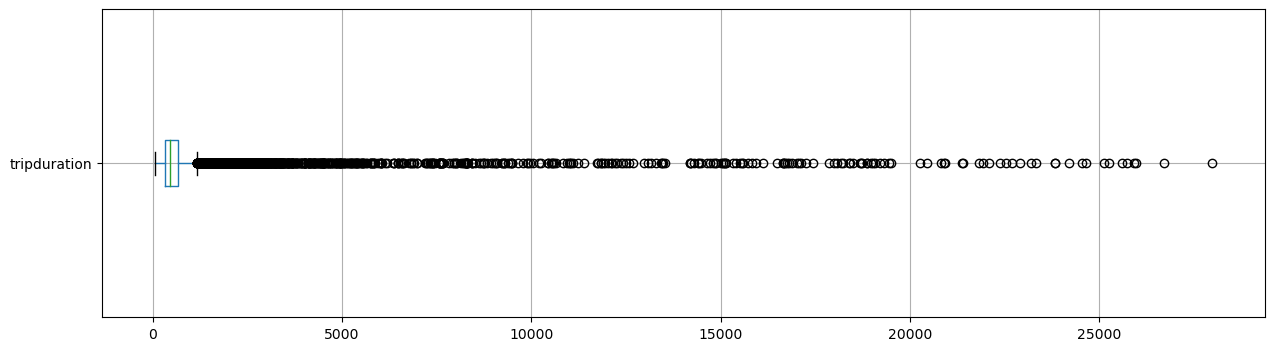

In [201]:
# Exercise 4
# Yes, there are outliers
df = data[mask_males]
box = df.boxplot(column=['tripduration'], vert=False, figsize = (15,4)) #add vert=False
plt.show()

In [202]:
# Exercise 5
# Listing 1-19 modified for trip_durations_of_males
q75, q25 = np.percentile(trip_durations_of_males, [75 ,25])
iqr = q75 - q25
print(f"Proportion of values as outlier: {((len(data) - len([x for x in trip_durations_of_males if q75+(1.5*iqr) >=x>= q25-(1.5*iqr)]))*100/float(len(data))):.4f} percent")

Proportion of values as outlier: 54.5638 percent


In [203]:
# Exercise 6-1
# Listing 1-21 modified for trip_durations_of_males
males_mean_trip_duration = np.mean([x for x in trip_durations_of_males if q75+(1.5*iqr) >=x>= q25-(1.5*iqr)])
males_upper_whisker = q75+(1.5*iqr)
print('Mean of trip duration: %f'%males_mean_trip_duration)

Mean of trip duration: 482.552272


In [204]:
trips = df['tripduration'].apply(lambda x: transform_tripduration(x, males_upper_whisker, males_mean_trip_duration))
trips

116828    406.541
13302     133.610
179564     61.203
133697    547.429
133730    475.856
           ...   
211796    730.355
163212    355.048
150337    248.395
10835     699.428
80889     482.552
Name: tripduration, Length: 112940, dtype: float64

In [205]:
df.loc[:,'trip_durations_of_males_mean'] = trips
df

/tmp/ipykernel_17313/1899586558.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'trip_durations_of_males_mean'] = trips


,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,...,birthyear,starttime_mod,starttime_date,starttime_year,starttime_month,starttime_day,starttime_hour,starttime_dayofweek,tripduration_mean,trip_durations_of_males_mean
116828,129239,2015-08-15 17:27:00,2015-08-15 17:34:00,SEA00051,406.541,Terry Ave & Stewart St,2nd Ave & Pine St,SLU-20,CBD-13,Member,...,1936.0,2015-08-15 17:27:00,2015-08-15,2015,8,15,17,Saturday,406.541,406.541
13302,16581,2014-11-23 16:46:00,2014-11-23 16:48:00,SEA00355,133.610,REI / Yale Ave N & John St,REI / Yale Ave N & John St,SLU-01,SLU-01,Member,...,1936.0,2014-11-23 16:46:00,2014-11-23,2014,11,23,16,Sunday,133.610,133.610
179564,195602,2016-04-03 19:02:00,2016-04-03 19:03:00,SEA00308,61.203,Terry Ave & Stewart St,Terry Ave & Stewart St,SLU-20,SLU-20,Member,...,1936.0,2016-04-03 19:02:00,2016-04-03,2016,4,3,19,Sunday,61.203,61.203
133697,147070,2015-09-20 16:06:00,2015-09-20 16:15:00,SEA00067,547.429,Terry Ave & Stewart St,2nd Ave & Pine St,SLU-20,CBD-13,Member,...,1936.0,2015-09-20 16:06:00,2015-09-20,2015,9,20,16,Sunday,547.429,547.429
133730,147105,2015-09-20 17:04:00,2015-09-20 17:12:00,SEA00460,475.856,2nd Ave & Pine St,Terry Ave & Stewart St,CBD-13,SLU-20,Member,...,1936.0,2015-09-20 17:04:00,2015-09-20,2015,9,20,17,Sunday,475.856,475.856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211796,229928,2016-07-05 17:31:00,2016-07-05 17:43:00,SEA00371,730.355,Bellevue Ave & E Pine St,King Street Station Plaza / 2nd Ave Extension ...,CH-12,PS-05,Member,...,1997.0,2016-07-05 17:31:00,2016-07-05,2016,7,5,17,Tuesday,730.355,730.355
163212,178334,2016-01-15 20:28:00,2016-01-15 20:34:00,SEA00052,355.048,UW Engineering Library / E Stevens Way NE & Je...,12th Ave & NE Campus Pkwy,UW-06,UD-04,Member,...,1997.0,2016-01-15 20:28:00,2016-01-15,2016,1,15,20,Friday,355.048,355.048
150337,164675,2015-11-05 19:00:00,2015-11-05 19:05:00,SEA00173,248.395,UW Engineering Library / E Stevens Way NE & Je...,15th Ave NE & NE 40th St,UW-06,UW-04,Member,...,1997.0,2015-11-05 19:00:00,2015-11-05,2015,11,5,19,Thursday,248.395,248.395
10835,13378,2014-11-13 17:25:00,2014-11-13 17:37:00,SEA00180,699.428,City Hall / 4th Ave & James St,Westlake Ave & 6th Ave,CBD-07,SLU-15,Member,...,1998.0,2014-11-13 17:25:00,2014-11-13,2014,11,13,17,Thursday,699.428,699.428


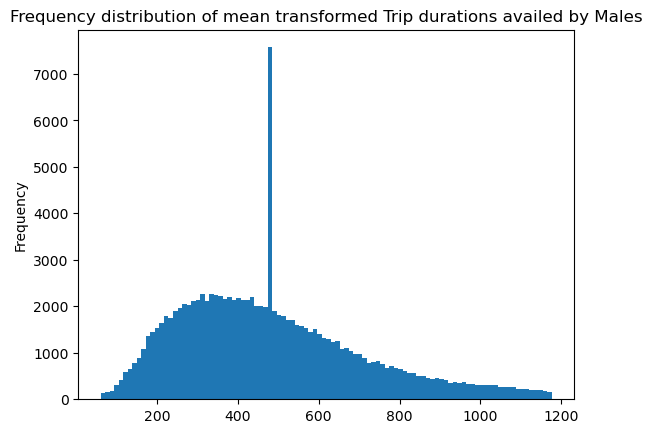

In [206]:
# Exercise 6-2
# Listing 1-23 modified for trip_durations_of_males
# trips = df['tripduration'].apply(lambda x: transform_tripduration(x, males_upper_whisker, males_mean_trip_duration)) # chaining this triggered the SettingWithCopyWarning


df['trip_durations_of_males_mean'].plot.hist(bins=100, title='Frequency distribution of mean transformed Trip durations availed by Males')
plt.show()

### Correlation directions

In [207]:
data.birthyear.describe()

count    146167.000
mean       1979.880
std          10.155
min        1931.000
25%        1975.000
50%        1983.000
75%        1987.000
max        1999.000
Name: birthyear, dtype: float64

### Before imputation of `birthyear`

In [208]:
birth_year = list(data['birthyear'])
print(f"Mean of birth year: {statistics.mean(birth_year)}")
print(f"Median of birth year: {statistics.median(birth_year)}")
print(f"Mode of birth year: {statistics.mode(birth_year)}")

Mean of birth year: nan
Median of birth year: 1988.0
Mode of birth year: 1987.0


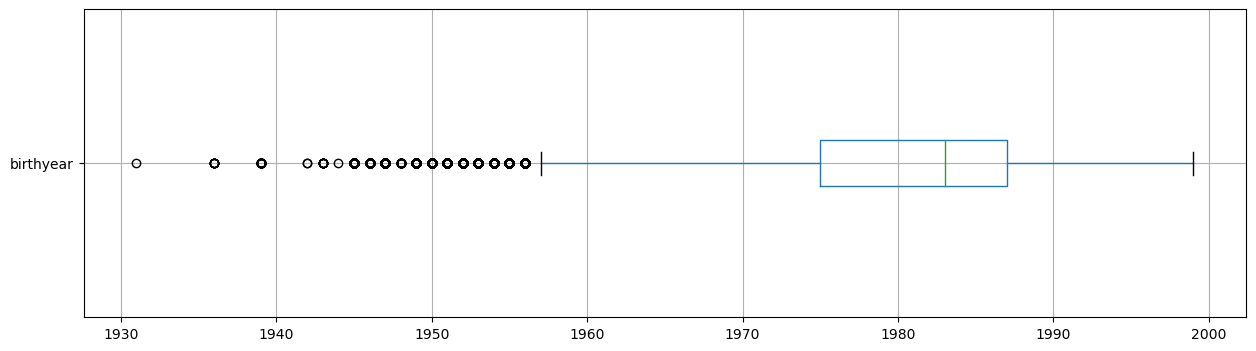

In [209]:
birthbox = data.boxplot(column=['birthyear'], vert=False, figsize = (15,4)) #add vert=False
plt.show()

In [210]:
backup = data.copy()
mask_birthyear_nan = data['birthyear'].isnull()

data.loc[mask_birthyear_nan, 'birthyear'] = statistics.median(birth_year)
data


,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear,starttime_mod,starttime_date,starttime_year,starttime_month,starttime_day,starttime_hour,starttime_dayofweek,tripduration_mean
212893,231080,2016-07-08 16:22:00,2016-07-08 16:53:00,SEA00423,1817.524,E Pine St & 16th Ave,E Pine St & 16th Ave,CH-07,CH-07,Member,Female,1931.0,2016-07-08 16:22:00,2016-07-08,2016,7,8,16,Friday,1817.524
116828,129239,2015-08-15 17:27:00,2015-08-15 17:34:00,SEA00051,406.541,Terry Ave & Stewart St,2nd Ave & Pine St,SLU-20,CBD-13,Member,Male,1936.0,2015-08-15 17:27:00,2015-08-15,2015,8,15,17,Saturday,406.541
13302,16581,2014-11-23 16:46:00,2014-11-23 16:48:00,SEA00355,133.610,REI / Yale Ave N & John St,REI / Yale Ave N & John St,SLU-01,SLU-01,Member,Male,1936.0,2014-11-23 16:46:00,2014-11-23,2014,11,23,16,Sunday,133.610
179564,195602,2016-04-03 19:02:00,2016-04-03 19:03:00,SEA00308,61.203,Terry Ave & Stewart St,Terry Ave & Stewart St,SLU-20,SLU-20,Member,Male,1936.0,2016-04-03 19:02:00,2016-04-03,2016,4,3,19,Sunday,61.203
133697,147070,2015-09-20 16:06:00,2015-09-20 16:15:00,SEA00067,547.429,Terry Ave & Stewart St,2nd Ave & Pine St,SLU-20,CBD-13,Member,Male,1936.0,2015-09-20 16:06:00,2015-09-20,2015,9,20,16,Sunday,547.429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236060,255241,2016-08-31 23:34:00,2016-08-31 23:45:00,SEA00201,679.532,Harvard Ave & E Pine St,2nd Ave & Spring St,CH-09,CBD-06,Short-Term Pass Holder,NaN,1988.0,2016-08-31 23:34:00,2016-08-31,2016,8,31,23,Wednesday,679.532
236062,255243,2016-08-31 23:47:00,2016-09-01 00:20:00,SEA00300,1951.173,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,1988.0,2016-08-31 23:47:00,2016-08-31,2016,8,31,23,Wednesday,1951.173
236061,255242,2016-08-31 23:48:00,2016-09-01 00:20:00,SEA00247,1965.418,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,1988.0,2016-08-31 23:48:00,2016-08-31,2016,8,31,23,Wednesday,1965.418
236063,255244,2016-08-31 23:49:00,2016-09-01 00:20:00,SEA00047,1883.299,Cal Anderson Park / 11th Ave & Pine St,6th Ave S & S King St,CH-08,ID-04,Short-Term Pass Holder,NaN,1988.0,2016-08-31 23:49:00,2016-08-31,2016,8,31,23,Wednesday,1883.299


### After imputation of `birthyear`

In [211]:
birth_year = list(data['birthyear'])
print(f"Mean of birth year: {statistics.mean(birth_year)}")
print(f"Median of birth year: {statistics.median(birth_year)}")
print(f"Mode of birth year: {statistics.mode(birth_year)}")

Mean of birth year: 1982.9720881960477
Median of birth year: 1988.0
Mode of birth year: 1988.0


In [212]:
print(data['birthyear'].isnull().sum())
print(data['starttime_year'].isna().sum())

0
0


In [213]:
# Listing 1-26

# pd.set_option('display.width', 100)
# pd.set_option('precision', 3)  # invalid, changed in newer version?

# data['age'] = data['starttime_year'] - data['birthyear']

# correlations = data[['tripduration','age']].corr(method='pearson')
# print(correlations)

### Default values before setting new values

In [214]:
print(f"display.width: {str(pd.options.display.width)}")
print(f"display.precision: {str(pd.options.display.precision)}")


display.width: 100
display.precision: 3


### Correlation Coefficient Between trip duration and age

In [215]:
pd.set_option('display.width', 100)
pd.set_option('display.precision', 3)

In [216]:
data['age'] = data['starttime_year'] - data['birthyear'] # coeffs changed from book after birthyear imputed vs dropped

correlations = data[['tripduration','age']].corr(method='pearson')
print(correlations)

              tripduration   age
tripduration          1.00 -0.15
age                  -0.15  1.00


### Pairplot of trip duration and age

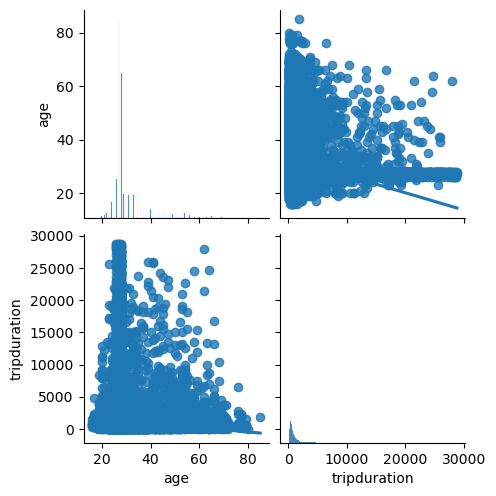

In [217]:
# Listing 1-25
# rearranged this to be after 1.26 because it is using 'age' feature which is engineered in 1-26
# data = data.dropna()
sns.pairplot(data, vars=['age', 'tripduration'], kind='reg')
plt.show()

# plot shows older people take longer bike trips, and all age groups take single trips lasting between 45-83 mins
# longest use of service is for about 3/4 of a day? 25000 s/60 min/24 hr = 17 hrs?? Is calculation correct?

### Computing Two-Tail t-test of Categories of gender and user types

In [218]:
# Listing 1-27

for cat in ['gender','usertype']:

    print(f"Category: \n{cat}")
    groupby_category = data.groupby(['starttime_date', cat])['starttime_date'].count().unstack(cat)
    # print(groupby_category)
    # groupby_category = groupby_category.dropna() # 'usertype' isna() dropped
    category_names = list(groupby_category.columns)
    print(category_names)

    for comb in [(category_names[i],category_names[j]) for i in range(len(category_names)) for j in range(i+1, len(category_names))]:

        print(f"{comb[0]}, {comb[1]}")
        t_statistics = stats.ttest_ind(list(groupby_category[comb[0]]), list(groupby_category[comb[1]]))
        print(f"Statistic: {t_statistics.statistic:.6f}, P value: {t_statistics.pvalue:.6f}")
        print('\n')

# since usertype for short-term users has no gender values and is dropped, there is no other usertype to compare to, how did book do it?
# book says 'gender' an 'age', though

Category: 
gender
['Female', 'Male', 'Other']
Female, Male
Statistic: -38.695436, P value: 0.000000


Female, Other
Statistic: nan, P value: nan


Male, Other
Statistic: nan, P value: nan


Category: 
usertype
['Member', 'Short-Term Pass Holder']
Member, Short-Term Pass Holder
Statistic: nan, P value: nan




### Script to Validate Central Limit Theorem on Trips Dataset

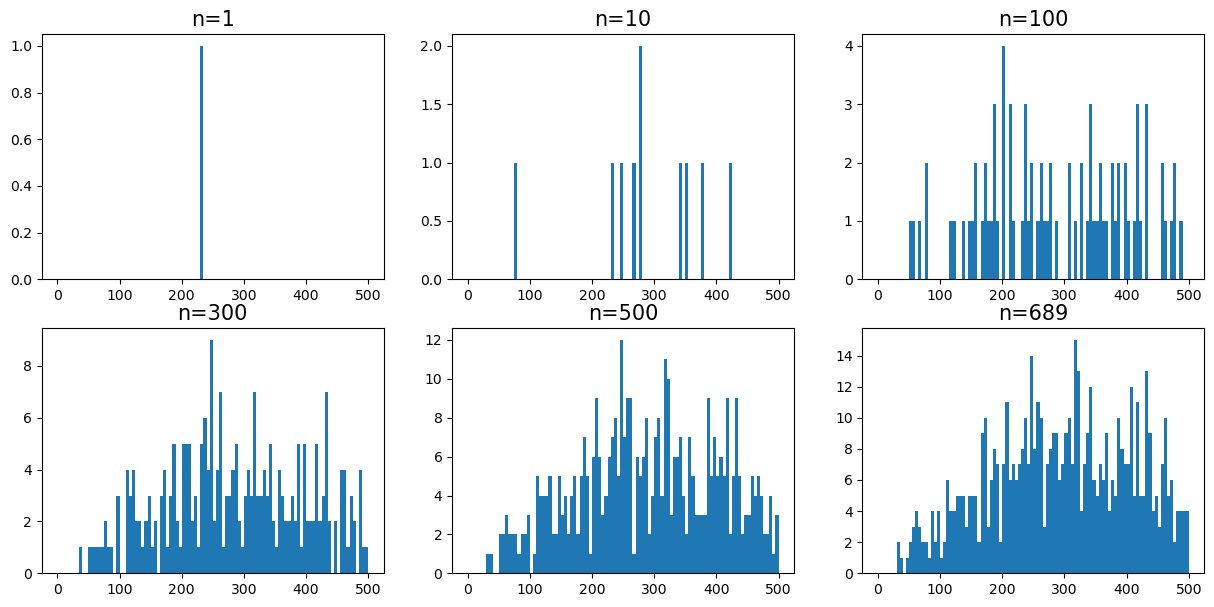

In [219]:
# Listing 1-28

daily_tickets = list(data.groupby('starttime_date').size())
sample_tickets = []
checkpoints = [1, 10, 100, 300, 500, 700]
plot_count = 1

random.shuffle(daily_tickets)

plt.figure(figsize=(15,7))
binrange=np.array(np.linspace(0,500,101))

for i in range(1000):
    if daily_tickets:
        sample_tickets.append(daily_tickets.pop())

    if i+1 in checkpoints or not daily_tickets:
        plt.subplot(2,3,plot_count)
        plt.hist(sample_tickets, binrange)
        plt.title('n=%d' % (i+1),fontsize=15)        
        plot_count+=1

    if not daily_tickets:
	    break
        
plt.show()

In [220]:
data.shape

(236065, 21)

In [221]:
print(f"No of records dropped due to 'gender' isna() {len(backup) - len(data)}") # dropped gender == NaN
print(f"Percentage of total:  {(len(backup) - len(data))/len(backup)*100}")

No of records dropped due to 'gender' isna() 0
Percentage of total:  0.0


excerpt from book:
> ## Case Study Findings

> Eric and Nancy’s deductions helped them understand their audience to a better extent
and garner valuables insights. The insights were rendered on data collected from 2014
to 2016 with demographic information only available for the members and not short-
term pass holders. Hence, in order to get information about the short-term pass holders
Nancy knew that she had to go through a market research exercise where central limit
theorem would come in handy. Trip duration follows a definite seasonal pattern that
repeats over time. Forecasting this time series can help Nancy predict the times when
the company needs to push its marketing efforts and times when most trips anticipated
can help ensure operational efficiencies. As for the promotions, Nancy now knew that
the best station at which to kick off the campaign would be Pier 69/Alaskan Way & Clay
St. Outliers were a tiny portion of the dataset; however, their time series nature meant
that those outliers couldn’t be removed and transformation was thus applied. Regarding
further analysis, Nancy was now aware that as the features are not homogeneous, the
analysis would have to be done on the individual category level.